# Imports

In [1]:
import collections
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textwrap import wrap
import pandas as pd

import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.probability import FreqDist
from collections import Counter

from keras import Input, Sequential
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, LSTM, SimpleRNN
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load English data
english_sentences = open('/content/drive/MyDrive/Dataset/small_vocab_en').read().split('\n')
# Load French data
french_sentences = open('/content/drive/MyDrive/Dataset/small_vocab_fr').read().split('\n')

print('Dataset Loaded')

Dataset Loaded


# EDA

In [4]:
english_words_counter = collections.Counter([word.lower() for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word.lower() for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
354 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [5]:
def generate_word_frequency(sentences):
    words = nltk.word_tokenize(" ".join(sentences))
    freq_dist = FreqDist(words)
    return freq_dist

In [6]:
eng_freq_dist = generate_word_frequency(english_sentences)
dict(eng_freq_dist)

{'new': 12197,
 'jersey': 11225,
 'is': 205882,
 'sometimes': 37746,
 'quiet': 8693,
 'during': 74933,
 'autumn': 9004,
 ',': 140897,
 'and': 59850,
 'it': 75377,
 'snowy': 8898,
 'in': 75525,
 'april': 8954,
 '.': 137049,
 'the': 67628,
 'united': 11270,
 'states': 11270,
 'usually': 37507,
 'chilly': 8770,
 'july': 8956,
 'freezing': 8928,
 'november': 8951,
 'california': 11250,
 'march': 9023,
 'hot': 8639,
 'june': 9133,
 'mild': 8743,
 'cold': 8878,
 'september': 8958,
 'your': 9734,
 'least': 27564,
 'liked': 14046,
 'fruit': 27192,
 'grape': 4848,
 'but': 63987,
 'my': 9700,
 'apple': 4848,
 'his': 9700,
 'favorite': 28332,
 'orange': 4848,
 'paris': 11334,
 'relaxing': 8696,
 'december': 8945,
 'busy': 8791,
 'spring': 9102,
 'never': 37500,
 'our': 8932,
 'lemon': 4848,
 'january': 9090,
 'warm': 8890,
 'lime': 4848,
 'her': 9700,
 'banana': 4848,
 'he': 10786,
 'saw': 648,
 'a': 1944,
 'old': 972,
 'yellow': 972,
 'truck': 1944,
 'india': 11277,
 'rainy': 8761,
 'that': 2712

In [7]:
fre_freq_dist = generate_word_frequency(french_sentences)
dict(fre_freq_dist)

{'new': 11047,
 'jersey': 11052,
 'est': 196809,
 'parfois': 37746,
 'calme': 7256,
 'pendant': 10741,
 'l': 32917,
 "'": 38029,
 'automne': 14727,
 ',': 123135,
 'et': 59851,
 'il': 84079,
 'neigeux': 1867,
 'en': 105768,
 'avril': 8954,
 '.': 137048,
 'les': 65255,
 'états-unis': 11210,
 'généralement': 31292,
 'froid': 16794,
 'juillet': 8956,
 'gèle': 3622,
 'habituellement': 6215,
 'novembre': 8951,
 'california': 3061,
 'mars': 9023,
 'chaud': 16405,
 'juin': 9133,
 'légère': 63,
 'fait': 2916,
 'septembre': 8958,
 'votre': 9368,
 'moins': 27557,
 'aimé': 25852,
 'fruit': 23626,
 'le': 35306,
 'raisin': 4852,
 'mais': 63987,
 'mon': 9403,
 'la': 49861,
 'pomme': 4848,
 'son': 16496,
 'préféré': 23305,
 "l'orange": 4848,
 'paris': 11334,
 'relaxant': 8458,
 'décembre': 8945,
 'occupé': 7782,
 'au': 25738,
 'printemps': 9100,
 'jamais': 37215,
 'chaude': 1124,
 'notre': 8319,
 'citron': 4848,
 'janvier': 9090,
 'chaux': 4848,
 'des': 2435,
 'fruits': 3566,
 'banane': 4848,
 'a': 13

## Visuals

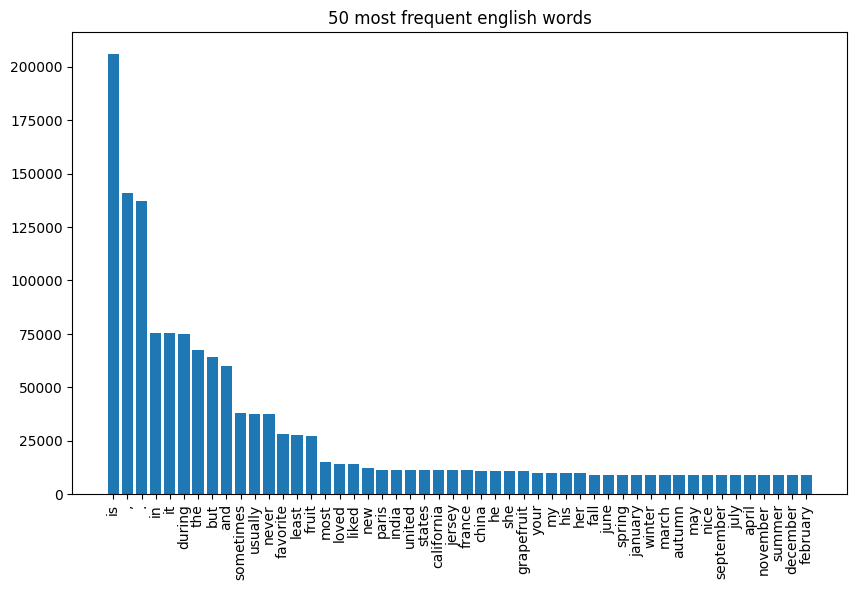

In [8]:
tf = pd.DataFrame({'term': list(eng_freq_dist.keys()), 'count': list(eng_freq_dist.values())})
tf1 = tf.nlargest(columns='count', n=50)
plt.figure(figsize=(10,6))
plt.bar(tf1['term'], tf1['count'])
plt.xticks(rotation='vertical')
plt.title("50 most frequent english words")
plt.show()

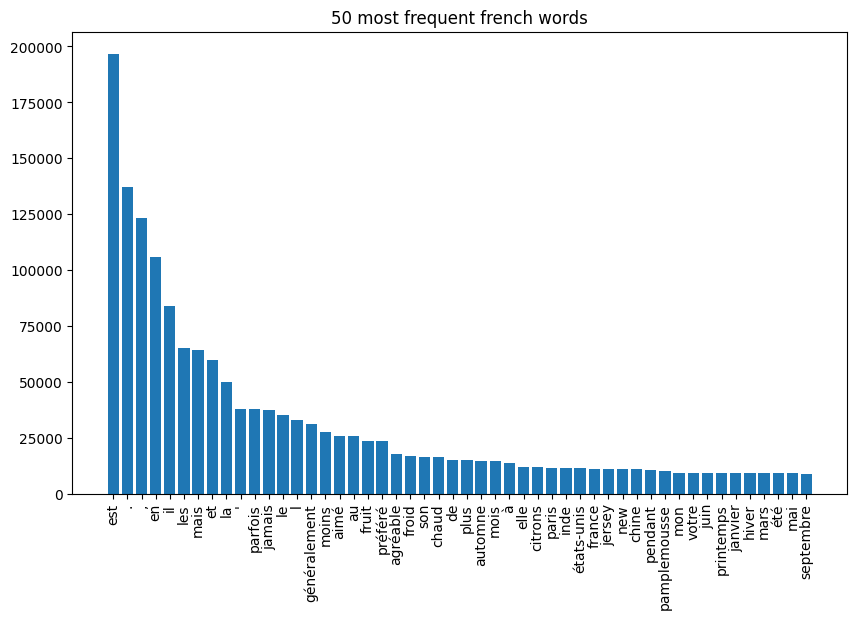

In [9]:
tf = pd.DataFrame({'term': list(fre_freq_dist.keys()), 'count': list(fre_freq_dist.values())})
tf1 = tf.nlargest(columns='count', n=50)
plt.figure(figsize=(10,6))
plt.bar(tf1['term'], tf1['count'])
plt.xticks(rotation='vertical')
plt.title("50 most frequent french words")
plt.show()

In [10]:
def generate_word_cloud(tokens, lang):
  word_cloud = WordCloud(width=400,height=330,max_words=50,colormap="Dark2",collocations = False).generate(tokens)
  # Display the generated Word Cloud
  plt.figure(figsize=(10,10))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.title("Word Cloud for {}".format(lang))
  plt.show()

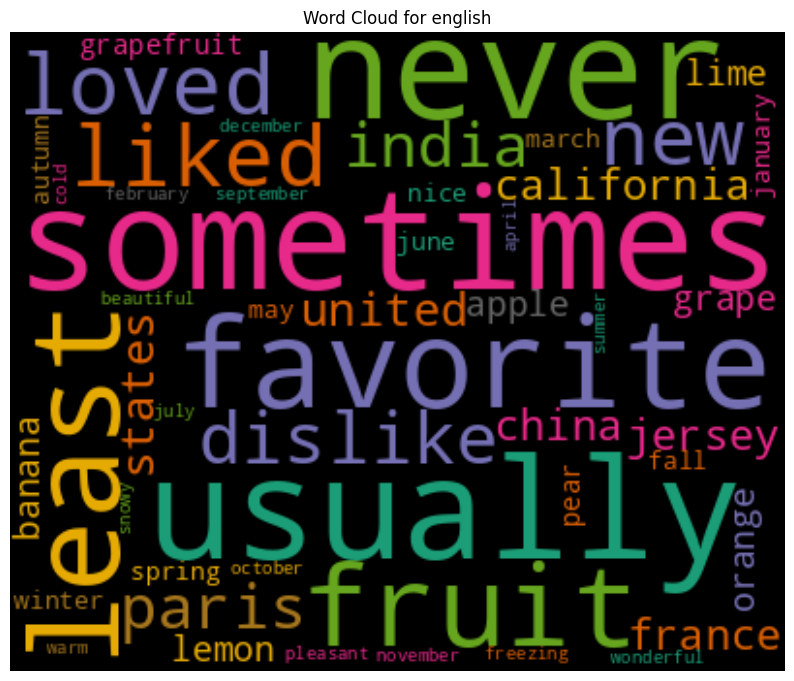

In [11]:
tokens = " ".join(english_sentences)
generate_word_cloud(tokens, 'english')

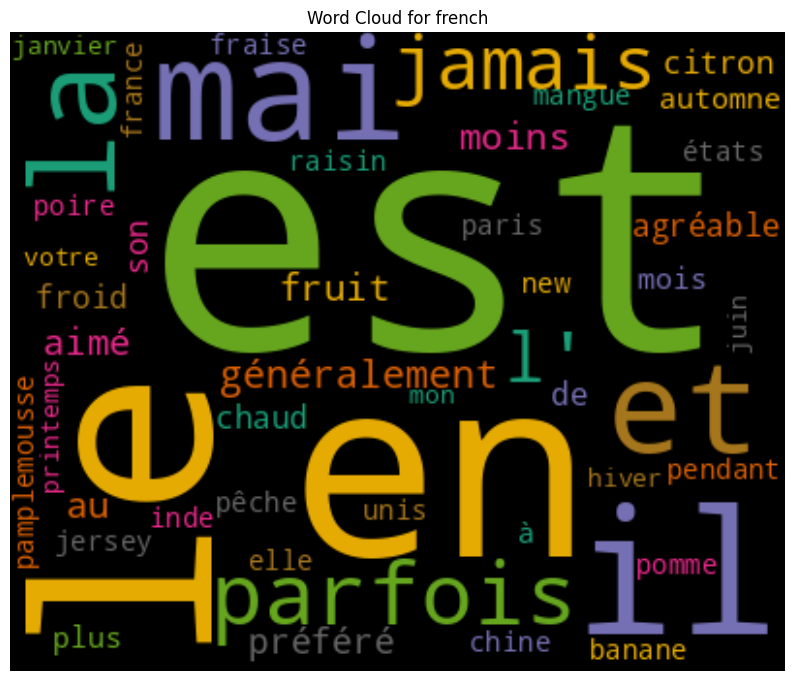

In [12]:
tokens = " ".join(french_sentences)
generate_word_cloud(tokens, 'french')

# Preprocess

In [13]:
def remove_punctuations(x):
  clean_texts = []
  for sentence in x:
    all_list = [char for char in sentence if char not in string.punctuation]
    clean_str = ''.join(all_list)
    clean_texts.append(clean_str)
  return clean_texts

# Remove punctuation Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
clean_texts = remove_punctuations(text_sentences)
print(clean_texts)
print()

['The quick brown fox jumps over the lazy dog ', 'By Jove  my quick study of lexicography won a prize ', 'This is a short sentence ']



In [14]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer(split=' ', char_level=False)
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer          

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()

for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [15]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    
    return pad_sequences(x, maxlen=length, padding='post', truncating='post')

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [16]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    x = remove_punctuations(x)
    y = remove_punctuations(y)

    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


# Models

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preproc_english_sentences, preproc_french_sentences, test_size=0.2, random_state=42)

## Utils

In [18]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1) if index_to_words[prediction]!='<PAD>'] )

In [19]:
def token_to_words(sequence, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return [index_to_words[token] for token in sequence if index_to_words[token]!='<PAD>']

In [20]:
def translate(prediction, gold_standard):
    
    translation = logits_to_text(prediction[0], french_tokenizer)
    standard = ' '.join(token_to_words(gold_standard[0][:,0],french_tokenizer)) 
    print('---- Gold standard ----')
    print(standard)
    print()
    print('---- Prediction ----')
    for w_t, w_s in zip(translation.split(), standard.split()):
        if w_t == w_s:
            print('\033[0;30;0m','{}'.format(w_t), end='')
        else:
            print('\033[0;31;47m', w_t, end='')
    print()

## RNN 

In [21]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 0.001
    english_input = Input(shape=input_shape[1:], name="input_layer")    # the shape is (input length x 1) as batchsize excluded
    
    # RNN takes as input (batchsize,input_length,1) and outputs (batchsize, input_length, 64) because return-seq=True
    x = SimpleRNN(64, return_sequences=True, activation="tanh", name="RNN_layer")(english_input)
    preds = TimeDistributed(Dense(french_vocab_size, activation="softmax"), name="Dense_layer")(x)
    model = Model(inputs=english_input, outputs=preds, name='simple_RNN')
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))  # reshape as 3D (batchsize, timesteps, 1) for RNN input

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

simple_rnn_model.summary()

simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)

Model: "simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 21, 1)]           0         
                                                                 
 RNN_layer (SimpleRNN)       (None, 21, 64)            4224      
                                                                 
 Dense_layer (TimeDistribute  (None, 21, 344)          22360     
 d)                                                              
                                                                 
Total params: 26,584
Trainable params: 26,584
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
108/108 [==============================] - 6s 24ms/step - loss: 3.3544 - accuracy: 0.4163 - val_loss: nan - val_accuracy: 0.4764
Epoch 2/20
108/108 [==============================] - 2s 20ms/step - loss: 2.4120 - accuracy: 0.4860 - val_los

In [22]:
# Print prediction(s)
print('---- Original ----')
print(' '.join(token_to_words(tmp_x[:1][0][:,0],english_tokenizer) ))
print()
translate(simple_rnn_model.predict(tmp_x[:1]), preproc_french_sentences[:1])

---- Original ----
new jersey is sometimes quiet during autumn and it is snowy in april

1/1 [==============================] - 0s 166ms/step
---- Gold standard ----
new jersey est parfois calme pendant l automne et il est neigeux en avril

---- Prediction ----
 la jersey est parfois chaud en en et il est est en en


## Encoder Decoder 

### LSTM

In [23]:
def enc_dec_model_lstm(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    
    learning_rate = 0.001
    embedding_size = 256
    units = 256
    
    model = Sequential()
    
    ########### ENCODER ###########
    
    model.add(Embedding(input_dim = english_vocab_size, output_dim = embedding_size, 
                           input_length= input_shape[1], name="Embedding_layer"))
    model.add(Bidirectional(LSTM(units, return_sequences=False, activation="relu"), name='Bi_LSTM_encoder'))
    
    ########### INTERMEDIARY ###########
    
    model.add(RepeatVector(output_sequence_length, name='Glue'))
    
    ########### DECODER ###########
    
    model.add(LSTM(units, return_sequences=True, name='LSTM_decoder', activation="relu"))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'), name='Dense'))
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model


tmp_x = pad(preproc_english_sentences, max_french_sequence_length) # pad input sequence to output sequence length
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))    # reshape for embedding input

# Train the neural network
lstm_model = enc_dec_model_lstm(
                        tmp_x.shape,
                        max_french_sequence_length,
                        english_vocab_size,
                        french_vocab_size)

lstm_model.summary()

lstm_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_layer (Embedding)  (None, 21, 256)          50944     
                                                                 
 Bi_LSTM_encoder (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 Glue (RepeatVector)         (None, 21, 512)           0         
                                                                 
 LSTM_decoder (LSTM)         (None, 21, 256)           787456    
                                                                 
 Dense (TimeDistributed)     (None, 21, 344)           88408     
                                                                 
Total params: 1,977,432
Trainable params: 1,977,432
Non-trainable params: 0
______________________________________________

In [24]:
print('---- Original ----')
print(' '.join(token_to_words(tmp_x[:1][0],english_tokenizer) ))
print()
translate(lstm_model.predict(tmp_x[:1]), preproc_french_sentences[:1])

---- Original ----
new jersey is sometimes quiet during autumn and it is snowy in april

1/1 [==============================] - 0s 368ms/step
---- Gold standard ----
new jersey est parfois calme pendant l automne et il est neigeux en avril

---- Prediction ----
 new jersey est parfois calme pendant l automne et il est neigeux en avril


### GRU

In [25]:
def enc_dec_model_gru(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    
    learning_rate = 0.001
    embedding_size = 512
    num_units = 256
    
    ########### ENCODER ###########
    encoder_input = Input(shape=input_shape[1:], name="input_Encoder")  
    
    embeddings = Embedding(input_dim = english_vocab_size, output_dim = embedding_size, 
                           input_length= input_shape[1], name="Embedding_layer")(encoder_input)
    
    encoder_output = Bidirectional(GRU(num_units, return_sequences=False, activation="tanh"), name="BiGRU_encoder")(embeddings)
    
    ########### INTERMEDIARY ###########
    sequenced_context_vector = RepeatVector(output_sequence_length)(encoder_output)
    
    ########### DECODER ###########
       
    x = GRU(num_units, return_sequences=True, activation="tanh", name="GRU_layer1")(sequenced_context_vector)
    x = GRU(num_units, return_sequences=True, activation="tanh", name="GRU_layer2")(x)
    
    preds = TimeDistributed(Dense(french_vocab_size, activation="softmax"), name="Dense_layer")(x)
    
    ########### END-TO-END MODEL ###########
    model = Model(inputs=encoder_input, outputs=preds, name='Encdec')
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model
    
tmp_x = pad(preproc_english_sentences, max_french_sequence_length) # pad input sequence to output sequence length
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))    # reshape for embedding input

# Train the neural network
gru_model = enc_dec_model_gru(
                        tmp_x.shape,
                        max_french_sequence_length,
                        english_vocab_size,
                        french_vocab_size)

gru_model.summary()

gru_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=25, validation_split=0.2)

Model: "Encdec"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_Encoder (InputLayer)  [(None, 21)]              0         
                                                                 
 Embedding_layer (Embedding)  (None, 21, 512)          101888    
                                                                 
 BiGRU_encoder (Bidirectiona  (None, 512)              1182720   
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 21, 512)          0         
 )                                                               
                                                                 
 GRU_layer1 (GRU)            (None, 21, 256)           591360    
                                                                 
 GRU_layer2 (GRU)            (None, 21, 256)           39475

In [26]:
print('---- Original ----')
print(' '.join(token_to_words(tmp_x[:1][0],english_tokenizer) ))
print()
translate(gru_model.predict(tmp_x[:1]), preproc_french_sentences[:1])

---- Original ----
new jersey is sometimes quiet during autumn and it is snowy in april

1/1 [==============================] - 1s 1s/step
---- Gold standard ----
new jersey est parfois calme pendant l automne et il est neigeux en avril

---- Prediction ----
 new jersey est parfois calme pendant l automne et il est neigeux en avril


# Evaluation

In [27]:
tmp_x1 = pad(X_test, max_french_sequence_length)
tmp_x1 = tmp_x1.reshape((-1, preproc_french_sentences.shape[-2], 1))

In [28]:
# Evaluate the RNN model on the test data
loss, accuracy = simple_rnn_model.evaluate(tmp_x1, y_test, verbose=0)

# Print the evaluation metrics
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.3144762516021729
Test accuracy: 0.6302663087844849


In [29]:
# Evaluate the encoder decoder LSTM model on the test data
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)

# Print the evaluation metrics
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5439186692237854
Test accuracy: 0.8802676200866699


In [30]:
# Evaluate the encoder decoder GRU model on the test data
loss, accuracy = gru_model.evaluate(X_test, y_test, verbose=0)

# Print the evaluation metrics
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.2837100625038147
Test accuracy: 0.9286500215530396


# Prediction

In [31]:
def model_predict(sentence):
  print("TRANSLATIONS:\n ")

  translations = []

  tmp_x = sentence.reshape((-1, y.shape[-2], 1))
  predictions = simple_rnn_model.predict(tmp_x)
  translation = logits_to_text(predictions[0], y_tk)
  translations.append(translation)
  print("RNN - {}".format(translation))

  predictions = lstm_model.predict(sentence)
  translation = logits_to_text(predictions[0], y_tk)
  translations.append(translation)
  print("LSTM - {}".format(translation))

  predictions = gru_model.predict(sentence)
  translation = logits_to_text(predictions[0], y_tk)
  translations.append(translation)
  print("GRU - {}".format(translation))

  return translations

In [2]:
x, y, x_tk, y_tk = preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer

sentence = 'he saw a old yellow truck'
sentence = [x_tk.word_index[word] for word in sentence.split()]
sentence = pad_sequences(x, maxlen=y.shape[1], padding='post', truncating='post')

translations = model_predict(sentence)

RNN - je ai vu un camion
LSTM - je ai vu un vieux camion jaune
GRU - il a vu un vieux camion jaune


# Save model

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
lstm_model.save('/content/drive/MyDrive/Dataset/saved_model/lstm_model.h5')
gru_model.save('/content/drive/MyDrive/Dataset/saved_model/gru_model.h5')

In [ ]:
np.save('preproc_english_sentences', preproc_english_sentences)
np.save('preproc_french_sentences', preproc_french_sentences)

In [ ]:
import pickle

# Save the tokenizer to a file
with open('english_tokenizer.pickle', 'wb') as handle:
    pickle.dump(english_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('french_tokenizer.pickle', 'wb') as handle:
    pickle.dump(french_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)